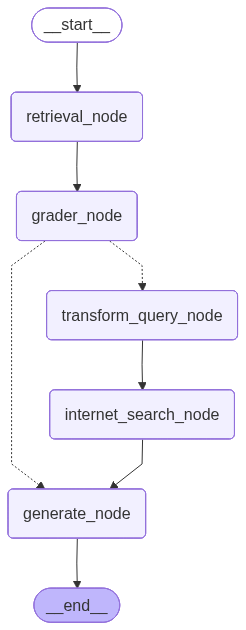

LangChain is important because it provides a framework for developing applications that utilize large language models (LLMs). It enables developers to effectively harness the power of LLMs by integrating them with other data sources and tools, making it easier to create complex language-based applications. The core components of LangChain include prompts, memory, chains, agents, and tools, which work together to facilitate the development of advanced language processing capabilities.


In [3]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from IPython.display import Image, display,Markdown
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from typing import TypedDict, Annotated, Literal
import os

# ----------------------------
#  Load environment & models
# ----------------------------
load_dotenv()
os.environ["LANGGRAPH_PROJECT"] = "Conversational_RAG"
llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings(model="text-embedding-3-small", dimensions=1024)

# ----------------------------
#  Define state
# ----------------------------
class ChatState(TypedDict):
    messages: Annotated[list, add_messages]  # Chat history reducer
    context: str
    grader: str

# ----------------------------
#  Load and process web docs
# ----------------------------
urls = [
    "https://aws.amazon.com/what-is/langchain/",
    "https://www.ibm.com/think/topics/langchain"
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [d for sublist in docs for d in sublist]

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
splitted_docs = splitter.split_documents(docs_list)

vectordb = Chroma.from_documents(splitted_docs, embeddings)
retriever = vectordb.as_retriever(search_kwargs={"k": 3})

# ----------------------------
#  Define workflow nodes
# ----------------------------

def retrieval_node(state: ChatState) -> ChatState:
    """Retrieve context from vector store."""
    user_msg = state["messages"][-1].content
    context_docs = retriever.invoke(user_msg)
    context_text = "\n\n".join([d.page_content for d in context_docs])
    return {"context": context_text, "messages": [AIMessage(content="I've retrieved relevant context.")]} 

def grader_node(state: ChatState) -> ChatState:
    """Grade context relevance."""
    question = state["messages"][-1].content
    context = state["context"]
    grader_prompt = f"Is the following context relevant to the question?\n\nQuestion: {question}\n\nContext: {context}\n\nAnswer Yes or No."
    grader_response = llm.invoke(grader_prompt)
    return {"grader": grader_response.content.strip(), "messages": [AIMessage(content=f"Grader says: {grader_response.content.strip()}")]} 

def generate_node(state: ChatState) -> ChatState:
    """Generate answer based on context."""
    question = state["messages"][-1].content
    context = state["context"]
    gen_prompt = f"Using the context below, answer the user's question.\n\nContext:\n{context}\n\nQuestion: {question}"
    result = llm.invoke(gen_prompt)
    return {"messages": [AIMessage(content=result.content)]}

def transform_query_node(state: ChatState) -> ChatState:
    """Rewrite unclear user query."""
    question = state["messages"][-1].content
    prompt = f"Rephrase this user query to make it clearer and grammatically correct:\n\n{question}"
    rewritten = llm.invoke(prompt)
    return {"messages": [AIMessage(content=f"Let me restate your question: {rewritten.content}")]} 

def internet_search_node(state: ChatState) -> ChatState:
    """Fetch additional info via Wikipedia."""
    api_wrapper = WikipediaAPIWrapper(top_k_results=2, doc_content_chars_max=300)
    wiki = WikipediaQueryRun(api_wrapper=api_wrapper)
    tools = [wiki]

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a research assistant who uses Wikipedia to find facts."),
        ("human", "{question}")
    ])
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, verbose=False)

    result = executor.invoke({"question": state["messages"][-1].content})
    return {"messages": [AIMessage(content=result["output"])]}

def grader_condition(state: ChatState) -> Literal["generate_node", "transform_query_node"]:
    if "Yes" in state["grader"]:
        return "generate_node"
    else:
        return "transform_query_node"

# ----------------------------
#  Build LangGraph
# ----------------------------
graph = StateGraph(ChatState)

graph.add_node("retrieval_node", retrieval_node)
graph.add_node("grader_node", grader_node)
graph.add_node("generate_node", generate_node)
graph.add_node("transform_query_node", transform_query_node)
graph.add_node("internet_search_node", internet_search_node)

graph.add_edge(START, "retrieval_node")
graph.add_edge("retrieval_node", "grader_node")
graph.add_conditional_edges("grader_node", grader_condition)
graph.add_edge("transform_query_node", "internet_search_node")
graph.add_edge("internet_search_node", "generate_node")
graph.add_edge("generate_node", END)

# ----------------------------
#  Compile & visualize
# ----------------------------
workflow = graph.compile()
display(Image(workflow.get_graph().draw_mermaid_png()))

# ----------------------------
#  Run chat-style invocation
# ----------------------------
result = workflow.invoke({"messages": [HumanMessage(content="what is LangChain used for?")]})
print(result["messages"][-1].content)


In [4]:
Markdown(result["messages"][-1].content)

LangChain is important because it provides a framework for developing applications that utilize large language models (LLMs). It enables developers to effectively harness the power of LLMs by integrating them with other data sources and tools, making it easier to create complex language-based applications. The core components of LangChain include prompts, memory, chains, agents, and tools, which work together to facilitate the development of advanced language processing capabilities.